In [18]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
csv_path = "qkd_attack_dataset_v3.csv"  # Replace with your actual file path
df = pd.read_csv(csv_path)
print(df.head())

   Num_Qubits_Sent  Num_Qubits_Measured_Correctly      QBER  \
0              602                           1353  0.110961   
1              935                           1232  0.096435   
2             1360                            539  0.278751   
3              770                           1191  0.035574   
4              606                            945  0.119535   

   Photon_Splitting_Prob  Intercept_Resend_Prob  Eavesdropper_Success_Rate  \
0               0.277457               0.070006                   0.692565   
1               0.377480               0.339186                   0.850066   
2               0.072751               0.036580                   1.507777   
3               0.307024               0.358663                   0.760745   
4               0.234740               0.161902                   0.178185   

   Final_Key_Length  Detector_Error_Rate  Quantum_Channel_Noise  \
0                60             0.032417               0.186467   
1               25

In [6]:
X = df.iloc[:, :-1].values  # Features (all columns except last)
y = df.iloc[:, -1].values   # Labels (last column)

In [7]:
if df.iloc[:, -1].dtype == 'object':  
    y = (y == "Attack").astype(int)  # Convert "Attack" -> 1, "No Attack" -> 0


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Normalize Features (Standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [10]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [11]:
class QKDAttackDetector(nn.Module):
    def __init__(self, input_size):
        super(QKDAttackDetector, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # 2 classes (Attack/No Attack)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Regularization to prevent overfitting
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

In [12]:
input_size = X_train.shape[1]  # Number of features
model = QKDAttackDetector(input_size)

# ✅ Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [13]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")


Epoch 1/20, Loss: 115.6289
Epoch 2/20, Loss: 108.3609
Epoch 3/20, Loss: 107.6904
Epoch 4/20, Loss: 107.5970
Epoch 5/20, Loss: 106.8316
Epoch 6/20, Loss: 106.5283
Epoch 7/20, Loss: 106.1915
Epoch 8/20, Loss: 105.8154
Epoch 9/20, Loss: 105.6482
Epoch 10/20, Loss: 105.2471
Epoch 11/20, Loss: 104.9659
Epoch 12/20, Loss: 104.8721
Epoch 13/20, Loss: 104.3205
Epoch 14/20, Loss: 104.1205
Epoch 15/20, Loss: 103.2063
Epoch 16/20, Loss: 103.6635
Epoch 17/20, Loss: 103.2114
Epoch 18/20, Loss: 102.5567
Epoch 19/20, Loss: 102.1416
Epoch 20/20, Loss: 101.8418


In [14]:
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

Accuracy: 0.9005

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93      1314
           1       0.94      0.76      0.84       686

    accuracy                           0.90      2000
   macro avg       0.91      0.87      0.88      2000
weighted avg       0.90      0.90      0.90      2000



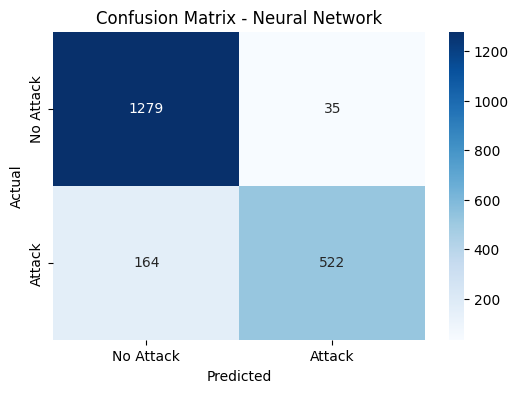

In [19]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred))
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Attack", "Attack"], yticklabels=["No Attack", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Neural Network")
plt.show()